# <b>Assignment : DT</b>

In [ ]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt  

import re

import pickle
from tqdm import tqdm
import os
from collections import Counter

from plotly.offline import iplot
import plotly.graph_objs as go


from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

from wordcloud import WordCloud, STOPWORDS 


sid = SentimentIntensityAnalyzer()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = "/content/drive/MyDrive/Colab Notebooks/Assignments/11 - Decision Tree on Donors Chase/"

In [ ]:
#please use below code to load glove vectors 
with open(path+'glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [ ]:
print("Glove vector dimension : ",model["student"].shape)

Glove vector dimension :  (300,)


or else , you can use below code

# <font color='red'> <b>Task - 1</b></font>

<ol>
    <li><strong>Apply Decision Tree Classifier(DecisionTreeClassifier) on these feature sets</strong>
        <ul>
            <li><font color='red'>Set 1</font>: categorical, numerical features +  preprocessed_essay (TFIDF) + Sentiment scores(preprocessed_essay)</li>
            <li><font color='red'>Set 2</font>: categorical, numerical features +  preprocessed_essay (TFIDF W2V) + Sentiment scores(preprocessed_essay)</li>        </ul>
    </li>
    <li><strong>The hyper paramter tuning (best `depth` in range [1, 5, 10, 50], and the best `min_samples_split` in range [5, 10, 100, 500])</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>find the best hyper paramter using k-fold cross validation(use gridsearch cv or randomsearch cv)/simple cross validation data(you can write your own for loops refer sample solution)</li>
        </ul>
    </li>
    <li>
    <strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='https://i.imgur.com/Gp2DQmh.jpg' width=500px> with X-axis as <strong>min_sample_split</strong>, Y-axis as <strong>max_depth</strong>, and Z-axis as <strong>AUC Score</strong> , we have given the notebook which explains how to plot this 3d plot, you can find it in the same drive <i>3d_scatter_plot.ipynb</i></li>
            <p style="text-align:center;font-size:30px;color:red;"><strong>or</strong></p> <br>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='https://i.imgur.com/fgN9aUP.jpg' width=300px> <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heat maps</a> with rows as <strong>min_sample_split</strong>, columns as <strong>max_depth</strong>, and values inside the cell representing <strong>AUC Score</strong> </li>
    <li>You choose either of the plotting techniques out of 3d plot or heat map</li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='https://i.imgur.com/wMQDTFe.jpg' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
    <img src='https://i.imgur.com/IdN5Ctv.png' width=300px></li>
    <li>Once after you plot the confusion matrix with the test data, get all the `false positive data points`
        <ul>
            <li> Plot the WordCloud(https://www.geeksforgeeks.org/generating-word-cloud-python/) with the words of essay text of these `false positive data points`</li>
            <li> Plot the box plot with the `price` of these `false positive data points`</li>
            <li> Plot the pdf with the `teacher_number_of_previously_posted_projects` of these `false positive data points`</li>
        </ul>
        </ul>
    </li>
   

# TASK 1 - SET 2 - TFIDF-W2V


In [ ]:
data = pd.read_csv(path+"preprocessed_data.csv",nrows=50000)
print(data.columns)
print(data.shape)

Index(['school_state', 'teacher_prefix', 'project_grade_category',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'clean_categories', 'clean_subcategories', 'essay', 'price'],
      dtype='object')
(50000, 9)


In [ ]:
# append sentiment scores
scores =  [sid.polarity_scores(x) for x in data["essay"]]

neg = []
neu = []
pos = []
comp = []
for score in scores:
  neg.append(score["neg"])
  neu.append(score["neu"])
  pos.append(score["pos"])
  comp.append(score["compound"])

data["neu"] = neu
data["compound"] = comp
data["neg"] = neg
data["pos"] = pos

In [ ]:
Y = data['project_is_approved'].values
X = data.drop(['project_is_approved'],axis=1)

In [ ]:
X.head(1)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,clean_categories,clean_subcategories,essay,price,neu,compound,neg,pos
0,ca,mrs,grades_prek_2,53,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05,0.783,0.9867,0.013,0.205


## Load Data

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, stratify=Y,random_state=0)
X_test_org = X_test.copy()

## Encoding Categorical Features

**SCHOOL STATE**

In [ ]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['school_state'].values)

X_train_state_ohe = vectorizer.transform(X_train['school_state'].values)
X_test_state_ohe = vectorizer.transform(X_test['school_state'].values)

**Teacher Prefix**

In [ ]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['teacher_prefix'].values) 

X_train_teacher_ohe = vectorizer.transform(X_train['teacher_prefix'].values)
X_test_teacher_ohe = vectorizer.transform(X_test['teacher_prefix'].values)

print("After vectorizations")
print(X_train_teacher_ohe.shape, y_train.shape)


After vectorizations
(33500, 5) (33500,)


**Project Grade Category**

In [ ]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['project_grade_category'].values) 

X_train_grade_ohe = vectorizer.transform(X_train['project_grade_category'].values)
X_test_grade_ohe = vectorizer.transform(X_test['project_grade_category'].values)

print("After vectorizations")
print(X_train_grade_ohe.shape, y_train.shape)

After vectorizations
(33500, 4) (33500,)


**clean_subcategories**

In [ ]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['project_grade_category'].values)

X_train_sub_cat_ohe = vectorizer.transform(X_train['clean_subcategories'].values)
X_test_sub_cat_ohe = vectorizer.transform(X_test['clean_subcategories'].values)

print("After vectorizations")
print(X_train_sub_cat_ohe.shape, y_train.shape)


After vectorizations
(33500, 30) (33500,)


**clean_categories**

In [ ]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['clean_categories'].values)

X_train_cat_ohe = vectorizer.transform(X_train['clean_categories'].values)
X_test_cat_ohe = vectorizer.transform(X_test['clean_categories'].values)
print("After vectorizations")
print(X_train_cat_ohe.shape, y_train.shape)

After vectorizations
(33500, 9) (33500,)


## Encoding Numerical Features

**PRICE**

In [ ]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()

normalizer.fit(X_train['price'].values.reshape(1,-1))

X_train_price_norm = normalizer.transform(X_train['price'].values.reshape(1,-1))
X_test_price_norm = normalizer.transform(X_test['price'].values.reshape(1,-1))

X_train_price_norm = X_train_price_norm.reshape(-1,1)
X_test_price_norm = X_test_price_norm.reshape(-1,1)



print("After vectorizations")
print(X_train_price_norm.shape, y_train.shape)
print(X_test_price_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(33500, 1) (33500,)
(16500, 1) (16500,)


**teacher_number_of_previously_posted_projects**

In [ ]:
# teacher_number_of_previously_posted_projects
normalizer1 = Normalizer()
normalizer1.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))

X_train_prev_proj_norm = normalizer1.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))
X_test_prev_proj_norm = normalizer1.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))

X_train_prev_proj_norm = X_train_price_norm.reshape(-1,1)
X_test_prev_proj_norm = X_test_price_norm.reshape(-1,1)


## TF-IDF W2V


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer


tfidf_model = TfidfVectorizer()
tfidf_model.fit(X_train['essay'].values)
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

In [ ]:
# average Word2Vec
# compute average word2vec for each review.
def train_tfdidf_w2v(data):
  tfidf_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
  for sentence in tqdm(data): # for each review/sentence
      vector = np.zeros(300) # as word vectors are of zero length
      tf_idf_weight =0; # num of words with a valid vector in the sentence/review
      for word in sentence.split(): # for each word in a review/sentence
          if (word in glove_words) and (word in tfidf_words):
              vec = model[word] # getting the vector for each word
              # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
              tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
              vector += (vec * tf_idf) # calculating tfidf weighted w2v
              tf_idf_weight += tf_idf
      if tf_idf_weight != 0:
          vector /= tf_idf_weight
      tfidf_w2v_vectors.append(vector)
  return tfidf_w2v_vectors


In [ ]:
X_train_essay_tfidf = train_tfdidf_w2v(X_train['essay'].values)
X_test_essay_tfidf = train_tfdidf_w2v(X_test['essay'].values)


100%|██████████| 16500/16500 [00:30<00:00, 548.02it/s]


## Concat features in df

In [ ]:
print(len(X_test_essay_tfidf))
print(len(X_test_essay_tfidf[0]))

16500
300


In [ ]:
def flat(df,field):
  return df[field].values.reshape(-1,1)

In [ ]:
from scipy.sparse import hstack
X_tr = hstack((X_train_essay_tfidf,flat(X_train,"neg"),flat(X_train,"neu"),flat(X_train,"pos"),flat(X_train,"compound"),X_train_state_ohe, X_train_teacher_ohe, X_train_grade_ohe, X_train_sub_cat_ohe, X_train_cat_ohe,X_train_price_norm,X_train_prev_proj_norm)).tocsr()
X_test = hstack((X_test_essay_tfidf,flat(X_test,"neg"),flat(X_test,"neu"),flat(X_test,"pos"),flat(X_test,"compound"), X_test_state_ohe, X_test_teacher_ohe, X_test_grade_ohe, X_test_sub_cat_ohe, X_test_cat_ohe,X_test_price_norm,X_test_prev_proj_norm)).tocsr()

print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print("="*100)

NameError: ignored

## Hyper paramater Tuning


In [ ]:
params = {
    "max_depth":[1, 5, 10, 50],
    "min_samples_split":[5, 10, 100, 500]
}
clf = GridSearchCV(DecisionTreeClassifier(),param_grid=params,scoring='roc_auc', return_train_score=True,cv=5)
clf.fit(X_tr,y_train)

In [ ]:
print(clf.best_estimator_.max_depth)
print(clf.best_estimator_.min_samples_split)


In [ ]:
depth_vals = clf.cv_results_["param_max_depth"]
min_sample_split_vals = clf.cv_results_["param_min_samples_split"]
auc_vals_cv = clf.cv_results_["mean_test_score"]

auc_vals_train = clf.cv_results_["mean_train_score"]

In [ ]:

trace1 = go.Scatter3d(x=depth_vals,y=min_sample_split_vals,z=auc_vals_train, name = 'train')
trace2 = go.Scatter3d(x=depth_vals,y=min_sample_split_vals,z=auc_vals_cv, name = 'Cross validation')
data = [trace1, trace2]

layout = go.Layout(scene = dict(
        xaxis = dict(title='min_samples_split'),
        yaxis = dict(title='max_depth'),
        zaxis = dict(title='AUC'),))

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='3d-scatter-colorscale')

## Fit Best Model

In [ ]:
best_model = DecisionTreeClassifier(min_samples_split=500,max_depth=10,class_weight='balanced')
best_model.fit(X_tr,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
from sklearn.metrics import roc_auc_score,accuracy_score
print("Test AUC : " ,roc_auc_score(y_test, best_model.predict_proba(X_test)[:,1]))
print("Train AUC : ",roc_auc_score(y_train, best_model.predict_proba(X_tr)[:,1]))

Test AUC :  0.6182209840286615
Train AUC :  0.7364182874772827


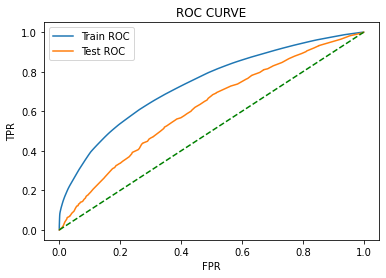

In [ ]:
from sklearn.metrics import roc_auc_score,roc_curve
# prob_a return probabilites for both - and + classes, keep only the + class probabilities
fpr_train,tpr_train,thresholds_train = roc_curve(y_train,best_model.predict_proba(X_tr)[:,1])
plt.plot(fpr_train,tpr_train)

fpr_test,tpr_test,thresholds_test = roc_curve(y_test,best_model.predict_proba(X_test)[:,1])
plt.plot(fpr_test,tpr_test)
plt.plot(np.linspace(0,1,20),np.linspace(0,1,20),"g--")

plt.legend(["Train ROC", "Test ROC"])
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC CURVE")
plt.show()

# roc_test = roc_curve(y_test,clf.predict_proba(X_test)[:,1])


In [ ]:
feat_imp = best_model.feature_importances_
print(feat_imp.shape)
idx = np.where(feat_imp > 0)
print(idx)

(405,)
(array([  0,   4,   6,  10,  13,  15,  16,  18,  20,  23,  26,  28,  30,
        32,  36,  39,  40,  41,  42,  45,  47,  50,  56,  60,  62,  63,
        68,  70,  71,  77,  78,  80,  83,  90,  96, 107, 109, 113, 117,
       124, 130, 131, 134, 138, 139, 144, 145, 148, 150, 154, 155, 157,
       159, 170, 171, 172, 179, 182, 186, 187, 189, 193, 196, 197, 205,
       206, 209, 211, 212, 216, 223, 234, 237, 239, 242, 245, 246, 247,
       250, 252, 261, 267, 280, 281, 282, 283, 285, 291, 299, 303, 307,
       403, 404]),)


## Confusion Matrix and Select False Positives

In [ ]:
from sklearn.metrics import plot_confusion_matrix,confusion_matrix
ypred = best_model.predict(X_test)
cfm = confusion_matrix(y_test,ypred)

ax= plt.subplot()
sns.heatmap(cfm, annot=True,fmt='d',cmap='Blues',ax=ax) #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('Actual labels'); 

### Select only False Positives

In [ ]:
X_test_org["pred"] = ypred
X_test_org["class"] = y_test
fp_df = X_test_org[(X_test_org["class"] == 0) & (X_test_org["pred"] == 1)]

In [ ]:
#Word Cloud
stopwords = set(STOPWORDS) 
corpus = " ".join([w for w in fp_df["essay"].values])
  
wordcloud = WordCloud(width = 800, height = 800, background_color ='white', stopwords = stopwords, min_font_size = 10).generate(corpus) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [ ]:
sns.boxplot(x="class", y="price", data=fp_df).set_title('Price Boxplot')

In [ ]:
sns.distplot(fp_df["teacher_number_of_previously_posted_projects"]).set_title('PDF teacher_number_of_previously_posted_projects')

# TASK 1 - SET 1 TFIDF

## Load Data

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, stratify=Y,random_state=0)
X_test_org = X_test.copy()

## Encoding Categorical Features

**SCHOOL STATE**

In [ ]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['school_state'].values)
X_train_state_ohe = vectorizer.transform(X_train['school_state'].values)
X_test_state_ohe = vectorizer.transform(X_test['school_state'].values)


**Teacher Prefix**

In [ ]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['teacher_prefix'].values) 
X_train_teacher_ohe = vectorizer.transform(X_train['teacher_prefix'].values)
X_test_teacher_ohe = vectorizer.transform(X_test['teacher_prefix'].values)

print("After vectorizations")
print(X_train_teacher_ohe.shape, y_train.shape)


After vectorizations
(33500, 5) (33500,)


**Project Grade Category**

In [ ]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['project_grade_category'].values)
X_train_grade_ohe = vectorizer.transform(X_train['project_grade_category'].values)
X_test_grade_ohe = vectorizer.transform(X_test['project_grade_category'].values)

print("After vectorizations")
print(X_train_grade_ohe.shape, y_train.shape)

After vectorizations
(33500, 4) (33500,)


**clean_subcategories**

In [ ]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['clean_subcategories'].values)
X_train_sub_cat_ohe = vectorizer.transform(X_train['clean_subcategories'].values)
X_test_sub_cat_ohe = vectorizer.transform(X_test['clean_subcategories'].values)

print("After vectorizations")
print(X_train_sub_cat_ohe.shape, y_train.shape)


After vectorizations
(33500, 30) (33500,)


**clean_categories**

In [ ]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['clean_categories'].values) 
X_train_cat_ohe = vectorizer.transform(X_train['clean_categories'].values)
X_test_cat_ohe = vectorizer.transform(X_test['clean_categories'].values)
print("After vectorizations")
print(X_train_cat_ohe.shape, y_train.shape)

After vectorizations
(33500, 9) (33500,)


## Encoding Numerical Features

**PRICE**

In [ ]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
normalizer.fit(X_train['price'].values.reshape(1,-1))

X_train_price_norm = normalizer.transform(X_train['price'].values.reshape(1,-1))
X_test_price_norm = normalizer.transform(X_test['price'].values.reshape(1,-1))

X_train_price_norm = X_train_price_norm.reshape(-1,1)
X_test_price_norm = X_test_price_norm.reshape(-1,1)



print("After vectorizations")
print(X_train_price_norm.shape, y_train.shape)
print(X_test_price_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(33500, 1) (33500,)
(16500, 1) (16500,)


**teacher_number_of_previously_posted_projects**

In [ ]:
# teacher_number_of_previously_posted_projects
normalizer1 = Normalizer()
normalizer1.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))

X_train_prev_proj_norm = normalizer1.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))
X_test_prev_proj_norm = normalizer1.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))

X_train_prev_proj_norm = X_train_price_norm.reshape(-1,1)
X_test_prev_proj_norm = X_test_price_norm.reshape(-1,1)


## TF-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
vectorizer.fit(X_train['essay'].values)


X_train_essay_tfidf = vectorizer.transform(X_train['essay'].values)
X_test_essay_tfidf = vectorizer.transform(X_test['essay'].values)


NameError: ignored

## Concat features in df

In [ ]:
def flat(df,field):
  return df[field].values.reshape(-1,1)


In [ ]:
from scipy.sparse import hstack
X_tr = hstack((X_train_essay_tfidf,flat(X_train,"neg"),flat(X_train,"neu"),flat(X_train,"pos"),flat(X_train,"compound"),X_train_state_ohe, X_train_teacher_ohe, X_train_grade_ohe, X_train_sub_cat_ohe, X_train_cat_ohe,X_train_price_norm,X_train_prev_proj_norm)).tocsr()
X_test = hstack((X_test_essay_tfidf,flat(X_test,"neg"),flat(X_test,"neu"),flat(X_test,"pos"),flat(X_test,"compound"), X_test_state_ohe, X_test_teacher_ohe, X_test_grade_ohe, X_test_sub_cat_ohe, X_test_cat_ohe,X_test_price_norm,X_test_prev_proj_norm)).tocsr()

print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print("="*100)

Final Data matrix
(33500, 35544) (33500,)
(16500, 35544) (16500,)


## Hyper paramater Tuning


In [ ]:
params = {
    "max_depth":[1, 5, 10, 50],
    "min_samples_split":[5, 10, 100, 500]
}
clf = GridSearchCV(DecisionTreeClassifier(),param_grid=params,scoring='roc_auc', return_train_score=True,cv=5)
clf.fit(X_tr,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': [1, 5, 10, 50],
                        

In [ ]:
print(clf.best_estimator_.max_depth)
print(clf.best_estimator_.min_samples_split)


10
500


In [ ]:
depth_vals = clf.cv_results_["param_max_depth"]
min_sample_split_vals = clf.cv_results_["param_min_samples_split"]
auc_vals_cv = clf.cv_results_["mean_test_score"]

auc_vals_train = clf.cv_results_["mean_train_score"]

In [ ]:
trace1 = go.Scatter3d(x=depth_vals,y=min_sample_split_vals,z=auc_vals_train, name = 'train')
trace2 = go.Scatter3d(x=depth_vals,y=min_sample_split_vals,z=auc_vals_cv, name = 'Cross validation')
data = [trace1, trace2]

layout = go.Layout(scene = dict(
        xaxis = dict(title='min_samples_split'),
        yaxis = dict(title='max_depth'),
        zaxis = dict(title='AUC'),))

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='3d-scatter-colorscale')

## Fit Best Model

In [ ]:
best_model = DecisionTreeClassifier(min_samples_split=clf.best_estimator_.min_samples_split,max_depth=clf.best_estimator_.max_depth)
best_model.fit(X_tr,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
from sklearn.metrics import roc_auc_score,accuracy_score
print("Test AUC : " ,roc_auc_score(y_test, best_model.predict_proba(X_test)[:,1]))
print("Train AUC : ",roc_auc_score(y_train, best_model.predict_proba(X_tr)[:,1]))

Test AUC :  0.6286621992352627
Train AUC :  0.6929938416014784


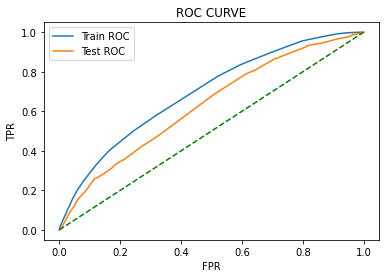

In [ ]:
from sklearn.metrics import roc_auc_score,roc_curve
# prob_a return probabilites for both - and + classes, keep only the + class probabilities
fpr_train,tpr_train,thresholds_train = roc_curve(y_train,best_model.predict_proba(X_tr)[:,1])
plt.plot(fpr_train,tpr_train)

fpr_test,tpr_test,thresholds_test = roc_curve(y_test,best_model.predict_proba(X_test)[:,1])
plt.plot(fpr_test,tpr_test)
plt.plot(np.linspace(0,1,20),np.linspace(0,1,20),"g--")

plt.legend(["Train ROC", "Test ROC"])
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC CURVE")
plt.show()


## Confusion Matrix and Select False Positives

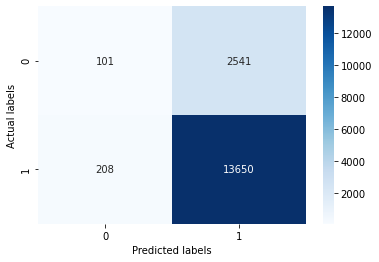

In [ ]:
from sklearn.metrics import plot_confusion_matrix,confusion_matrix
ypred = best_model.predict(X_test)
cfm = confusion_matrix(y_test,ypred)

ax= plt.subplot()
sns.heatmap(cfm, annot=True,fmt='d',cmap='Blues',ax=ax) #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('Actual labels'); 

### Select only False Positives

In [ ]:
X_test_org["pred"] = ypred
X_test_org["class"] = y_test
fp_df = X_test_org[(X_test_org["class"] == 0) & (X_test_org["pred"] == 1)]

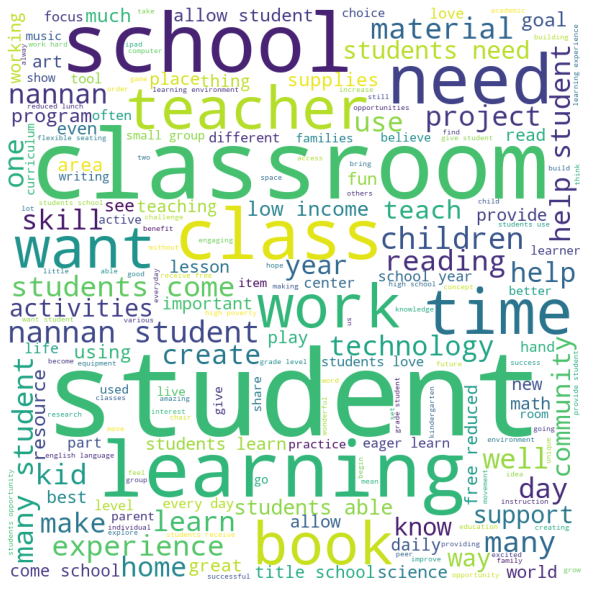

In [ ]:
#Word Cloud
stopwords = set(STOPWORDS) 
corpus = " ".join([w for w in fp_df["essay"].values])
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(corpus) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

Text(0.5, 1.0, 'Price Boxplot')

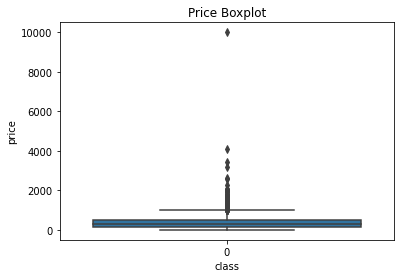

In [ ]:
sns.boxplot(x="class", y="price", data=fp_df).set_title("Price Boxplot")

Text(0.5, 1.0, 'PDF teacher_number_of_previously_posted_projects')

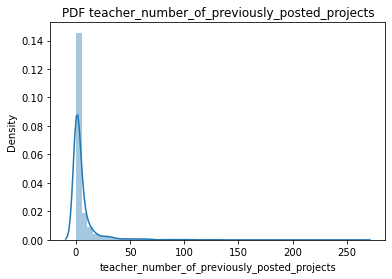

In [ ]:
sns.distplot(fp_df["teacher_number_of_previously_posted_projects"]).set_title('PDF teacher_number_of_previously_posted_projects')

# <font color='red'><b> Task - 2 </b></font>

For this task consider **set-1** features.

*  Select all the features which are having non-zero feature importance.You can get the feature importance using  'feature_importances_` 
   (https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html), discard the all other remaining features and then apply any of the model of you choice i.e. (Dession tree, Logistic Regression, Linear SVM).
*  You need to do hyperparameter tuning corresponding to the model you selected and procedure in step 2 and step 3<br>
  **Note**: when you want to find the feature importance make sure you don't use max_depth parameter keep it None.
  </li>
    <br>
You need to summarize the results at the end of the notebook, summarize it in the table format
        <img src='http://i.imgur.com/YVpIGGE.jpg' width=400px>
    </li>
</ol>

## Select only non zero features from Set 1

In [ ]:
model = DecisionTreeClassifier(min_samples_split=clf.best_estimator_.min_samples_split,max_depth=None)
model.fit(X_tr,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
feat_imp = model.feature_importances_
non_zero_feat = np.where(feat_imp > 0)[0]

In [ ]:
# select only the non zero features
def get_non_zero_features(data,feats):
  df = pd.DataFrame(data.todense())
  df = df.iloc[:,feats]
  return df

In [ ]:
X_tr_new = get_non_zero_features(X_tr,non_zero_feat)
X_test_new = get_non_zero_features(X_test,non_zero_feat)

## Linear SVM

In [ ]:
params = {
    "alpha":[0.0001,0.001,0.01,0.1,1,10,50,100,1000],
}
clf = GridSearchCV(SGDClassifier(loss="hinge"),param_grid=params,scoring='roc_auc',cv=5)
clf.fit(X_tr_new,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=SGDClassifier(alpha=0.0001, average=False,
                                     class_weight=None, early_stopping=False,
                                     epsilon=0.1, eta0=0.0, fit_intercept=True,
                                     l1_ratio=0.15, learning_rate='optimal',
                                     loss='hinge', max_iter=1000,
                                     n_iter_no_change=5, n_jobs=None,
                                     penalty='l2', power_t=0.5,
                                     random_state=None, shuffle=True, tol=0.001,
                                     validation_fraction=0.1, verbose=0,
                                     warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 50, 100,
                                   1000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             

In [ ]:
best_a = clf.best_estimator_.alpha
print(best_a)

0.1


Reference : SGD with loss="hinge" doesnt have predict_proba() function <br>
Solution: use clf.decision_function() <br>
https://stackoverflow.com/questions/39200265/attributeerror-probability-estimates-are-not-available-for-loss-hinge

In [ ]:
from sklearn.linear_model import SGDClassifier
a = SGDClassifier(loss="hinge",alpha=best_a).fit(X_tr_new,y_train)
# print(a)

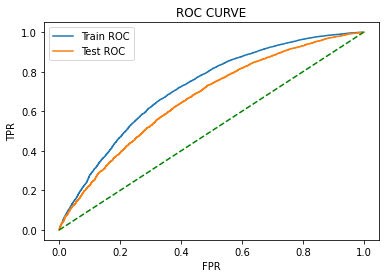

In [ ]:
from sklearn.metrics import roc_auc_score,roc_curve
fpr_train,tpr_train,thresholds_train = roc_curve(y_train,a.decision_function(X_tr_new))
plt.plot(fpr_train,tpr_train)

fpr_test,tpr_test,thresholds_test = roc_curve(y_test,a.decision_function(X_test_new))
plt.plot(fpr_test,tpr_test)
plt.plot(np.linspace(0,1,20),np.linspace(0,1,20),"g--")

plt.legend(["Train ROC", "Test ROC"])
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC CURVE")
plt.show()



In [ ]:
print("AUC SCORE : ",roc_auc_score(y_test,a.decision_function(X_test_new)))

AUC SCORE :  0.6662749370193557


## Logistic Regression

In [ ]:
from sklearn.linear_model import SGDClassifier

In [ ]:
params = {
    "alpha":[0.0001,0.001,0.01,0.1,1,10,50,100,1000],
}
clf = GridSearchCV(SGDClassifier(loss="log"),param_grid=params,scoring='roc_auc',cv=5)
clf.fit(X_tr_new,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=SGDClassifier(alpha=0.0001, average=False,
                                     class_weight=None, early_stopping=False,
                                     epsilon=0.1, eta0=0.0, fit_intercept=True,
                                     l1_ratio=0.15, learning_rate='optimal',
                                     loss='log', max_iter=1000,
                                     n_iter_no_change=5, n_jobs=None,
                                     penalty='l2', power_t=0.5,
                                     random_state=None, shuffle=True, tol=0.001,
                                     validation_fraction=0.1, verbose=0,
                                     warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 50, 100,
                                   1000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             sc

In [ ]:
lr_clf = SGDClassifier(loss="log",alpha = clf.best_estimator_.alpha)
lr_clf.fit(X_tr_new,y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

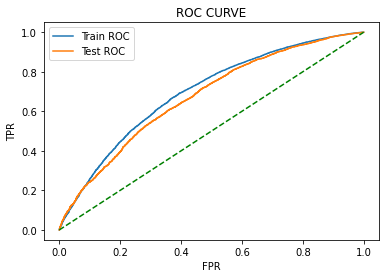

In [ ]:
from sklearn.metrics import roc_auc_score,roc_curve
# prob_a return probabilites for both - and + classes, keep only the + class probabilities
fpr_train,tpr_train,thresholds_train = roc_curve(y_train,lr_clf.predict_proba(X_tr_new)[:,1])
plt.plot(fpr_train,tpr_train)

fpr_test,tpr_test,thresholds_test = roc_curve(y_test,lr_clf.predict_proba(X_test_new)[:,1])
plt.plot(fpr_test,tpr_test)
plt.plot(np.linspace(0,1,20),np.linspace(0,1,20),"g--")

plt.legend(["Train ROC", "Test ROC"])
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC CURVE")
plt.show()


In [ ]:
print("AUC SCORE : ",roc_auc_score(y_test,lr_clf.predict_proba(X_test_new)[:,1]))

AUC SCORE :  0.6726971109257966


## Conclusion

In [ ]:
from prettytable import PrettyTable
table = PrettyTable()

table.field_names = ["Vectorizer", "Model", "Hyper Parameter", "AUC"]

table.add_row(["TFIDF", "Linear SVM", "alpha : 0.01", 0.6662749370193557])
table.add_row(["TFIDF", "Logistic Regression", "alpha : 0.0001", 0.6726971109257966])

print(table)

+------------+---------------------+-----------------+--------------------+
| Vectorizer |        Model        | Hyper Parameter |        AUC         |
+------------+---------------------+-----------------+--------------------+
|   TFIDF    |      Linear SVM     |   alpha : 0.01  | 0.6662749370193557 |
|   TFIDF    | Logistic Regression |  alpha : 0.0001 | 0.6726971109257966 |
+------------+---------------------+-----------------+--------------------+


In [ ]:
!jupyter nbconvert --to html "/content/Assignment_DT_Instructions_(1).ipynb"

[NbConvertApp] Converting notebook /content/Assignment_DT_Instructions_(1).ipynb to html
[NbConvertApp] Writing 1468878 bytes to /content/Assignment_DT_Instructions_(1).html


## Test

In [66]:
def pair_sum(arr, target):
  res = []

  arr = sorted(arr)
  lo,hi = 0, len(arr)-1

  while lo < hi:
    cur = arr[lo]+arr[hi]
    # print(lo,hi)
    if cur == target:
      lcount = 1
      rcount = 1
      res_pair = (arr[lo],arr[hi])
      while lo<hi and arr[lo]==arr[lo+1]:
        lcount += 1
        lo += 1
      while lo<hi and arr[hi]==arr[hi-1]:
        rcount += 1
        hi -= 1
      lo += 1
      hi -= 1
      for _ in range(lcount*rcount):
        res.append(res_pair)
    elif cur > target:
      hi -= 1
    else:
      lo += 1
  
  return res

In [72]:
# arr = [1,2,3,3,4,4,4,4,6]
# pair_sum(arr, 6)

# arr = [1,2,3,4,5 ]
# pair_sum(arr, 5)

# arr = [1,2,3,4,4,6]
# pair_sum(arr, 6)

arr = [2, 2, 2, 2, 2, 2]
pair_sum(arr, 4)


[(2, 2), (2, 2), (2, 2), (2, 2), (2, 2), (2, 2)]

In [73]:
a = ["A","A","A","B","B","B","C","C"]
b = [12,34,123,34,45,23,54,56]
res = [123,123,34,34,1,2,3435,234]

df = pd.DataFrame({"col1":a, "col2":b, "label":res})

In [74]:
df.corr()

,col2,label
col2,1.000000,0.070323
label,0.070323,1.000000
